In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt

In [2]:
# Path to the XML file exported form Apple Health app
XML_DATA = "C:/Users/LHAGELS/Downloads/Export/apple_health_export/Export.xml"

In [3]:
# Parse XML file exported from Apple Health app
tree = ET.parse(XML_DATA)
root = tree.getroot()

In [1]:
for child in root:
    print(child.tag, child.attrib)

NameError: name 'root' is not defined

### Records

In [15]:
# Store "Record" type data into Pandas.DataFrame
records = [i.attrib for i in root.iter("Record")]
df_records = pd.DataFrame(records)

In [27]:
# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    df_records[col] = pd.to_datetime(df_records[col])

# value is numeric, NaN if fails
df_records['value'] = pd.to_numeric(df_records['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
df_records['value'] = df_records['value'].fillna(1.0)

# shorter observation names
df_records['type'] = df_records['type'].str.replace('HKQuantityTypeIdentifier', '')
df_records['type'] = df_records['type'].str.replace('HKCategoryTypeIdentifier', '')
df_records.tail()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
1530545,HeartRateVariabilitySDNN,Apple Watch von Lucas,9.6,ms,2023-07-29 02:02:54+02:00,2023-07-29 02:01:53+02:00,2023-07-29 02:02:52+02:00,91.5934,"<<HKDevice: 0x2814a7c50>, name:Apple Watch, ma..."
1530546,HeartRateVariabilitySDNN,Apple Watch von Lucas,9.6,ms,2023-07-29 04:02:57+02:00,2023-07-29 04:01:56+02:00,2023-07-29 04:02:55+02:00,120.3930,"<<HKDevice: 0x2814a7c50>, name:Apple Watch, ma..."
1530547,HeartRateVariabilitySDNN,Apple Watch von Lucas,9.6,ms,2023-07-29 06:02:54+02:00,2023-07-29 06:01:53+02:00,2023-07-29 06:02:52+02:00,90.2865,"<<HKDevice: 0x2814a7c50>, name:Apple Watch, ma..."
1530548,HeartRateVariabilitySDNN,Apple Watch von Lucas,9.6,ms,2023-07-29 08:03:22+02:00,2023-07-29 08:02:21+02:00,2023-07-29 08:03:21+02:00,130.3270,"<<HKDevice: 0x2814a7c50>, name:Apple Watch, ma..."
1530549,HeartRateVariabilitySDNN,Apple Watch von Lucas,9.6,ms,2023-07-29 12:26:11+02:00,2023-07-29 12:25:09+02:00,2023-07-29 12:26:09+02:00,25.1187,"<<HKDevice: 0x2814a7c50>, name:Apple Watch, ma..."


### Workouts

In [30]:
workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame
df_workout = pd.DataFrame(workout_list)
df_workout['workoutActivityType'] = df_workout['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
df_workout = df_workout.rename({"workoutActivityType": "Type"}, axis=1)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    df_workout[col] = pd.to_datetime(df_workout[col])

# convert string to numeric   
df_workout['duration'] = pd.to_numeric(df_workout['duration'])
#df_workout['totalEnergyBurned'] = pd.to_numeric(df_workout['totalEnergyBurned'])
#df_workout['totalDistance'] = pd.to_numeric(df_workout['totalDistance'])
df_workout.tail()

,Type,duration,durationUnit,sourceName,sourceVersion,creationDate,startDate,endDate,device
508,Running,29.191795,min,Apple Watch von Lucas,9.5.2,2023-07-27 07:10:39+02:00,2023-07-27 06:41:22+02:00,2023-07-27 07:10:33+02:00,"<<HKDevice: 0x2814e2c10>, name:Apple Watch, ma..."
509,TraditionalStrengthTraining,48.807983,min,Apple Watch von Lucas,9.6,2023-07-27 19:32:16+02:00,2023-07-27 18:43:25+02:00,2023-07-27 19:32:14+02:00,"<<HKDevice: 0x2814ef390>, name:Apple Watch, ma..."
510,Walking,42.871661,min,Apple Watch von Lucas,9.6,2023-07-28 21:35:18+02:00,2023-07-28 20:52:22+02:00,2023-07-28 21:35:15+02:00,"<<HKDevice: 0x2814ef390>, name:Apple Watch, ma..."
511,Running,88.617171,min,Apple Watch von Lucas,9.6,2023-07-29 10:13:17+02:00,2023-07-29 08:44:22+02:00,2023-07-29 10:13:04+02:00,"<<HKDevice: 0x2814ef390>, name:Apple Watch, ma..."
512,Walking,45.043913,min,Apple Watch von Lucas,9.6,2023-07-29 11:59:10+02:00,2023-07-29 11:14:05+02:00,2023-07-29 11:59:08+02:00,"<<HKDevice: 0x2814ef390>, name:Apple Watch, ma..."


In [31]:
num_workouts = df_workout.shape[0]

In [32]:
def get_workouts(df, workout_type):
    return df[df["Type"] == workout_type]

# to see the different workout types use:
print(df_workout.Type.unique())
# ['Running' 'FunctionalStrengthTraining' 'Yoga'
#  'HighIntensityIntervalTraining' 'CoreTraining']

running_data = get_workouts(df_workout, "Running")

['Cycling' 'Yoga' 'PreparationAndRecovery' 'FunctionalStrengthTraining'
 'Walking' 'Cooldown' 'HighIntensityIntervalTraining' 'Running'
 'TraditionalStrengthTraining' 'CoreTraining' 'Swimming' 'Bowling'
 'DownhillSkiing']


In [41]:
def get_workouts_from_to(df, start, end):
    start = pd.to_datetime(start, utc=True)
    end = pd.to_datetime(end, utc=True)
    workouts = df[df["creationDate"] >= start]
    workouts = workouts[workouts["creationDate"] <= end]
    return workouts

lower_time = dt.date(2022, 1, 1)
upper_time = dt.date.today()
workouts = get_workouts_from_to(df_workout, lower_time, upper_time)

In [42]:
last_workout = workouts.iloc[[-1]]

In [44]:
def get_heartrate_for_workout(heartrate, workout):
    def get_heartrate_for_date(hr, start, end):
        hr = hr[hr["startDate"] >= start]
        hr = hr[hr["endDate"] <= end]
        return hr
    return get_heartrate_for_date(heartrate, workout["startDate"].item(), workout["endDate"].item())

heartrate_data = df_records[df_records["type"] == "HeartRate"]

# Extract heartrate statistics for certain workout
last_workout = workouts.iloc[[-1]]
heartrate_workout = get_heartrate_for_workout(heartrate_data, last_workout)
minh = heartrate_workout["value"].min()
maxh = heartrate_workout["value"].max()
meanh = heartrate_workout["value"].mean()
print(last_workout.Type.item(), minh, maxh, meanh)

Walking 76.0 140.0 99.33995584988962


<Axes: xlabel='endDate'>

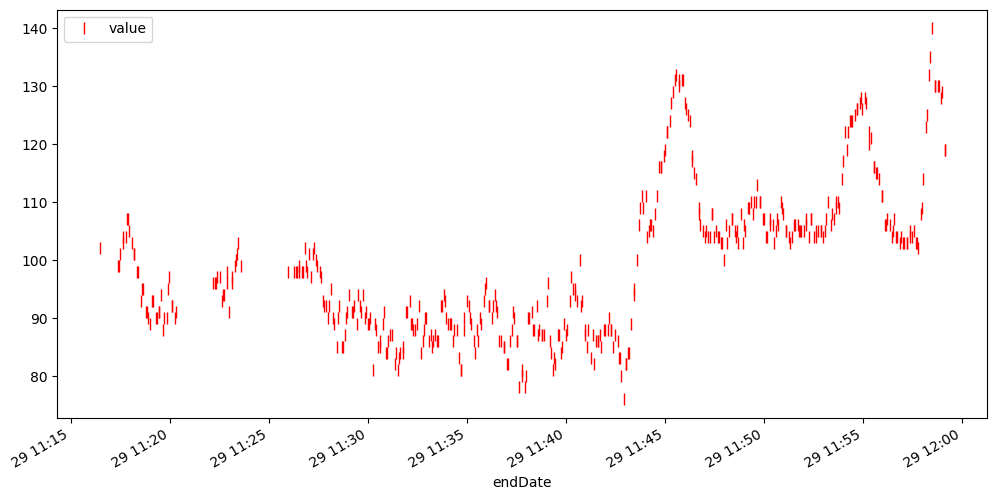

In [45]:
heartrate_workout.plot(x='endDate', y='value', style='r|', markersize=8.5,  figsize=(12, 6))

In [51]:
df_workout.columns

Index(['Type', 'duration', 'durationUnit', 'sourceName', 'sourceVersion',
       'creationDate', 'startDate', 'endDate', 'device', 'heartrate',
       'hr_mean'],
      dtype='object')

In [50]:
def get_hr_for_workout_row(df_workout, heartrate):
    def get_hr_for_date(hr, start, end):
        hr = hr[hr["startDate"] >= start]
        hr = hr[hr["endDate"] <= end]
        return hr
    return get_hr_for_date(heartrate, df_workout["startDate"], df_workout["endDate"])

def convert_to_minute_proportion(number):
    return int(number) + ((number % 1) / 100 * 60)

def get_pace_for_workout(df_workout):
    if df_workout["totalDistance"] == 0.0:
        return 0.0
    # pace=min/km
    pace = df_workout["duration"] / df_workout["totalDistance"]
    return convert_to_minute_proportion(pace)


df_workout["heartrate"] = df_workout.apply(lambda row: get_hr_for_workout_row(row, heartrate_data), axis=1)
df_workout["hr_mean"] = df_workout.apply(lambda row: row['heartrate']["value"].mean(), axis=1)
df_workout["pace"] = df_workout.apply(lambda row: get_pace_for_workout(row), axis=1)

KeyError: 'totalDistance'

In [ ]:
def get_stats(workouts):
    total_kcal = workouts["totalEnergyBurned"].sum()
    total_dist = workouts["totalDistance"].sum()
    total_time = workouts["duration"].sum()
    total_time_hours = convert_to_minute_proportion(total_time / 60)
    total_time_mins = convert_to_minute_proportion(total_time)

    avg_kcal = workouts["totalEnergyBurned"].mean()
    avg_dist = workouts[workouts["Type"] == "Running"]["totalDistance"].mean()
    avg_pace = workouts[workouts["Type"] == "Running"]["pace"].mean()
    avg_time = workouts["duration"].mean()
    avg_time_hours = convert_to_minute_proportion(avg_time / 60)
    avg_time_mins = convert_to_minute_proportion(avg_time)

    print(f"Workout statistics from {lower_time} to {upper_time-dt.timedelta(days=1)}")
    print(f"{workouts.shape[0]} workouts")
    print(f"Time: {total_time_mins:.2f} minutes ({total_time_hours:.2f} hours)\nCalories burned: {total_kcal:.2f}kcal\nRunning distance: {total_dist:.2f}km")
    print("\nAverage per workout:")
    print(f"Time: {avg_time_mins:.2f} minutes ({avg_time_hours:.2f} hours)\nCalories burned: {avg_kcal:.2f}kcal\nRunning distance: {avg_dist:.2f}km\nRunning pace: {avg_pace:.2f}km/h")

get_stats(workouts)

In [ ]:
def plot_workouts(workouts):
    labels = []
    slices = []
    for wo_type in workouts.Type.unique():
        labels.append(wo_type)
        wo_of_type = workouts[workouts["Type"] == wo_type]
        num_workouts_of_type = wo_of_type.shape[0]
        slices.append(num_workouts_of_type)

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return my_autopct

    plt.figure(figsize=(10, 10))
    plt.pie(slices, labels=labels, shadow=True,
            startangle=90, autopct=make_autopct(slices),
            wedgeprops={'edgecolor': 'black'})

    plt.title("Workouts in 2021")
    plt.tight_layout()
    plt.show()

plot_workouts(workouts)